<a href="https://colab.research.google.com/github/sebavassou/CatsandDogsModelTransferLearning/blob/main/CatsandDogsModelTransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Visão Geral do Projeto
O objetivo é aplicar Transfer Learning em uma rede neural profunda usando Python no ambiente Google Colab. O projeto se baseará no exemplo do MNIST, mas será adaptado para classificar imagens de gatos e cachorros.
Dataset Cats vs Dogs
O dataset "Cats vs Dogs" é uma coleção extensa de imagens de gatos e cachorros, ideal para tarefas de classificação binária2. Algumas características importantes do dataset incluem:
•	Tamanho total: 1.04 GiB
•	Número de exemplos: 23,262 imagens no conjunto de treinamento
•	Formato das imagens: RGB (3 canais de cor)
•	Classes: 2 (gato e cachorro)
É importante notar que o dataset original continha algumas imagens corrompidas, mas essas foram removidas na versão atual2.
Implementação do Transfer Learning
Para implementar o Transfer Learning, seguimos estas ações:
1.	Carregar o dataset: Use a API do TensorFlow Datasets para carregar os dados:

import tensorflow_datasets as tfds

dataset, info = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True)

2.	Pré-processar as imagens: Redimensione e normalize as imagens para se adequarem ao modelo pré-treinado que você escolher.

3.	Escolher um modelo base: Selecione um modelo pré-treinado, como VGG16, ResNet50 ou InceptionV3, disponível no Keras.

4.	Congelar as camadas base: Para preservar os pesos pré-treinados:
python

base_model.trainable = False

5.	Adicionar novas camadas: Adicione camadas densas no topo do modelo base para a classificação específica de gatos e cachorros.

6.	Compilar e treinar: Compile o modelo com um otimizador adequado e treine-o com os dados de gatos e cachorros.

7.	Fine-tuning: Opcionalmente, descongele algumas camadas superiores do modelo base e faça um fine-tuning com uma taxa de aprendizado baixa.

Considerações Adicionais:

•	O dataset está disponível para download direto da Microsoft, com um tamanho de 786.7 MB
•	Utilizamos o Google Colab para aproveitar os recursos de GPU gratuitos, o que pode acelerar significativamente o treinamento do modelo.
•	Consideramos usar técnicas de aumento de dados (data augmentation) para melhorar a generalização do modelo, especialmente considerando o número relativamente pequeno de imagens no dataset.



In [2]:
# Importando as bibliotecas necessárias
#import tensorflow as tf
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.applications import VGG16
#from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
#from tensorflow.keras.models import Model
#import matplotlib.pyplot as plt
#import os
#from PIL import UnidentifiedImageError

In [1]:
!pip install pillow_heif

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import os
from PIL import Image, UnidentifiedImageError
import pillow_heif

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 59.4 MB/s eta 0:00:00


In [2]:
# Configurando o TensorFlow para usar GPU, se disponível
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
# Definindo parâmetros
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10

In [5]:
# Baixando e extraindo o dataset
!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
!unzip -q kagglecatsanddogs_5340.zip

--2025-02-18 18:33:16--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 184.29.22.44, 2600:1406:bc00:1387::317f, 2600:1406:bc00:138c::317f
Connecting to download.microsoft.com (download.microsoft.com)|184.29.22.44|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_5340.zip.1’

kagglecatsanddogs_5 100%[===================>] 786.67M   232MB/s    in 3.3s    

2025-02-18 18:33:19 (237 MB/s) - ‘kagglecatsanddogs_5340.zip.1’ saved [824887076/824887076]



In [6]:
# Preparando os geradores de dados
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    'PetImages',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    'PetImages',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [7]:
# Carregando o modelo base VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
# Adicionando novas camadas
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

In [9]:
# Compilando o modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [10]:
# Function to handle image loading errors
def load_image_with_error_handling(img_path):
    try:
        # Attempt to open the image using Pillow
        img = Image.open(img_path)
        # Convert HEIC images to RGB if needed
        if img.format == "HEIF":
            img = img.convert("RGB")
        # Resize and convert to array
        img = img.resize(IMG_SIZE)
        img = tf.keras.utils.img_to_array(img)
        return img
    except (UnidentifiedImageError, OSError) as e:
        print(f"Error loading image {img_path}: {e}")
        return None

In [12]:
#import os
#from PIL import Image

#def verify_images(directory):
#    bad_images = []
#    for filename in os.listdir(directory):
#        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp')):
#            try:
#                img_path = os.path.join(directory, filename)
#                with Image.open(img_path) as img:
#                    img.verify()
#            except (IOError, SyntaxError) as e:
#                print(f'Bad file: {filename}: {e}')
#                bad_images.append(filename)
#    return bad_images
#
# Replace 'PetImages' with the actual path to your image directory
#image_directory = 'PetImages'
#bad_files = verify_images(image_directory)
#print(f'Total bad images found: {len(bad_files)}')

Total bad images found: 0


In [22]:
import os
from PIL import Image, UnidentifiedImageError

def verify_images(directory):
    bad_images = []
    for filename in os.listdir(directory):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):  # Added '.gif'
            try:
                img_path = os.path.join(directory, filename)
                with Image.open(img_path) as img:
                    img.verify()  # Verify image integrity
            except (IOError, SyntaxError, UnidentifiedImageError) as e:  # Added UnidentifiedImageError
                print(f'Bad file: {filename}: {e}')
                bad_images.append(img_path)  # Append the path, not just filename
    return bad_images

# Replace 'PetImages' with the actual path to your image directory
image_directory = 'PetImages'
bad_files = verify_images(image_directory)
print(f'Total bad images found: {len(bad_files)}')

# Remove the bad files
for bad_file in bad_files:
    os.remove(bad_file)
    print(f"Removed bad file: {bad_file}")

Total bad images found: 0


In [23]:
# Custom generator with error handling
def data_generator(generator):
    while True:
        batch_x, batch_y = next(generator)
        # Filter out images that couldn't be loaded
        valid_indices = [i for i, img in enumerate(batch_x) if img is not None]

        # If valid_indices is empty, yield the original batch
        # This prevents the IndexError
        if not valid_indices:
            # If all images in the batch are invalid, yield the original batch
            # or handle the error in another way, like printing a message
            yield batch_x, batch_y
            # or
            # print("Warning: Skipping batch with all invalid images.")
            # continue  # Skip the batch if preferred
        else:
            yield batch_x[valid_indices], batch_y[valid_indices]

In [24]:
# Create custom generators for training and validation
train_generator_wrapped = data_generator(train_generator)
validation_generator_wrapped = data_generator(validation_generator)


In [26]:
# Treinando o modelo
# Now use the wrapped generators
history = model.fit(
    train_generator_wrapped,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator_wrapped,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=EPOCHS
)

IndexError: list index out of range

NameError: name 'history' is not defined

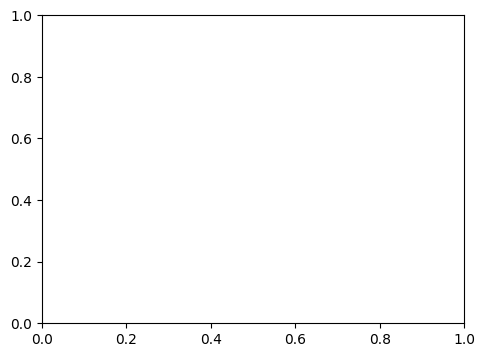

In [21]:
# Plotando os resultados
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia do Modelo')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda do Modelo')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Fine-tuning (opcional)
base_model.trainable = True
for layer in base_model.layers[:15]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=5
)


In [ ]:
# Salvando o modelo
model.save('cats_vs_dogs_model.h5')
